# Computing bilateral travel times using Python's igraph library
This code was created by Kalle Kappner and adapted by Andrea Herrera in 03/2024 for the course  "Quantitative Spatial Economics" dictated by Professor Gabriel Ahlfeldt at Humboldt-Universität zu Berlin.  

## 0. Loading packages and shapefiles

In [21]:
# !pip install python-igraph
# !pip install mapclassify

import igraph
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point

In [2]:
## Set Root Directory
from pathlib import Path

ROOT_FOLDER = str(Path().absolute().parent.parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


In [3]:
#!pip install dill
#import dill
#dill.load_session('C:/Users/andre/Dropbox/_HUB_HerreraA/Course/Repository/Workspaces_by_Topic/Topic_09/travel_time_session.db')

In [4]:
# Upload shapefiles
gdfZones = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/COUNTIES/VG250_KRS_clean_final.shp')
gdfUBahn = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/ROADS/ROADS_2015.shp')
# gdfUBahn = gpd.read_file(f'{ROOT_FOLDER}/notebooks/tutorial_11/data/ROADS_2015_ADJUSTED.shp')

#gdfStreets = gdfStreets.to_crs(3035)
gdfZones = gdfZones.to_crs(3035)
gdfUBahn = gdfUBahn.to_crs(3035)

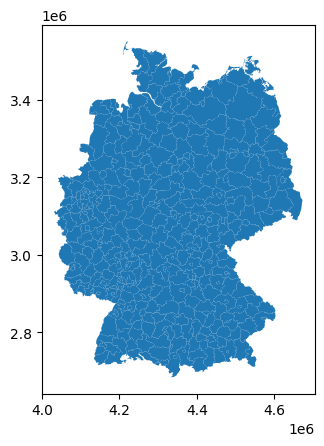

In [5]:
# Exploring the zones #
gdfZones.plot();

## I. Road Network to Graph

### 1. Preparing the network shapefile

In [6]:
#Prepare Road shapefile for conversion into Graph.

#If you want people to be able to change streets at every intersection, perform a self-intersection of the street shapefile with itself.
#Otherwise, only common vertices will be recognized as nodes.

n_segments_before_split = len(gdfUBahn)

unary = gdfUBahn.geometry.unary_union
gdfUBahn.geometry = gdfUBahn.geometry.buffer(0.01) #float arithmetic correction, see https://gis.stackexchange.com/questions/380054/self-split-geopandas-linestring-geodataframe-in-a-fast-way-without-loosing-all-a
geom = [i for i in unary.geoms]
id = [j for j in range(len(geom))]
unary = gpd.GeoDataFrame({'id':id, 'geometry':geom}, crs=3035)
gdfUBahn = gpd.sjoin(unary, gdfUBahn, how='inner', predicate='within')

n_segments_after_split = len(gdfUBahn)

print(f'Segments before split: {n_segments_before_split}.')
print(f'Segments after split: {n_segments_after_split}.')

#Assign travel time to each segment. EPSG:3035 is in meters. #In ARSW2015, they assumed travel speeds of 25 km/h for underground and suburban rail travel (Section S.6.3.).
gdfUBahn['travel_time'] = gdfUBahn['ttime_min']  #((gdfUBahn.length / 1000) / 25) * 60

#Assign unique IDs and clean dataframe.
gdfUBahn = gdfUBahn.reset_index()
gdfUBahn = gdfUBahn.drop(columns=['index_right'])

/var/folders/h8/qt6pgrpx2rq06gmv_wr3nbwr0000gn/T/ipykernel_85097/1019391690.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unary = gdfUBahn.geometry.unary_union


Segments before split: 327582.
Segments after split: 327823.


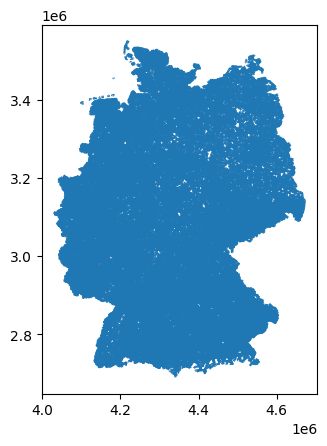

In [7]:
# Exploring the UBahn network #
gdfUBahn.plot();

### 2. Preparing zone shapefile for conversion into Graph

In [8]:
#Prepare the zone shapefile for conversion into a Graph.

#How do people reach the street network from a given zone?
#Easiest assumption: They start from the zone's centroid and travel along a straight line to the closest vertix in the street network.
#(It's a bit more complicated if you want to allow people to enter the street network at any point (not only the pre-existing vertices). In that case, you would need to linearly reference and then to split the streets at these "entering points". See also https://stackoverflow.com/questions/24415806/coordinates-of-the-closest-points-of-two-geometries-in-shapely .
#Get the zones' centroids:
gdfZonesCentroids = gdfZones.copy()
gdfZonesCentroids = gdfZonesCentroids[gdfZonesCentroids.is_valid]
gdfZonesCentroids.geometry = gdfZonesCentroids.geometry.centroid

#Get the start and end coordinates of each street segment - these are the valid "entering points" into the network.
first_coords = gdfUBahn.geometry.apply(lambda g: g.coords[0])
last_coords = gdfUBahn.geometry.apply(lambda g: g.coords[-1])
entryPoints = set(list(first_coords) + list(last_coords)) #Use set logic to avoid duplicated vertice coordinates.
gdfUBahnVertices = gpd.GeoDataFrame(geometry=gpd.points_from_xy([tpl[0] for tpl in entryPoints], [tpl[1] for tpl in entryPoints]), crs=3035)

#Use geopandas's sjoin_nearest to find the closest street network vertice for each zonal centroid, then build straight lines.
mappingZoneToVertice = gpd.sjoin_nearest(gdfZonesCentroids, gdfUBahnVertices, how='left')['index_right'].to_dict()
lines = []
for zone, vertice in mappingZoneToVertice.items():
  ptStart = gdfZonesCentroids.loc[zone, 'geometry']
  ptEnd = gdfUBahnVertices.loc[vertice, 'geometry']
  line = LineString([ptStart, ptEnd])
  lines.append(line)

gdfConnections = gpd.GeoDataFrame(geometry=lines, crs=3035)
gdfConnections['travel_time'] = ((gdfConnections.length / 1000) / 40) * 60 #Assume 40km/h

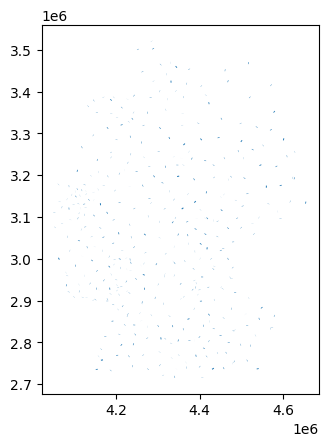

In [9]:
gdfConnections.plot();

### 3. Doing the graph with igraph

In [10]:
#Join the street network and the OD-to-streets connections into a single dataframe.
gdfNetwork = pd.concat([gdfUBahn, gdfConnections])

#igraph wants origin and destination IDs as the first two columns, so let's build a mapping that assigns a unique ID to each node and store those into columns.
dictIDs = {coord:id for id, coord in enumerate(list(zip(gdfZonesCentroids.geometry.x, gdfZonesCentroids.geometry.y)) + list(entryPoints))}
gdfNetwork['oID'] = gdfNetwork.apply(lambda row: dictIDs[row.geometry.coords[0]], axis=1)
gdfNetwork['dID'] = gdfNetwork.apply(lambda row: dictIDs[row.geometry.coords[-1]], axis=1)
gdfNetwork = gdfNetwork[['oID', 'dID'] + [col for col in gdfNetwork.columns.to_list() if not col in ['oID', 'dID']]] #Change the order of the columns.

In [11]:
#Build graph.
G = igraph.Graph.DataFrame(gdfNetwork, directed=False)

In [12]:
#By construction, our zones are the first N_zones IDs in our mapping, so we can easily recover their IDs.
mappingPlzToID = {int(plz):id for id, plz in enumerate(gdfZones['kreis_id'])}

### 4. Checking the network

In [13]:
#Find the travel time from Berlin to Munich:
oID = mappingPlzToID[11000] #Berlin
dID = mappingPlzToID[9162] #Munich
times = G.distances(source=[oID], target=[dID], weights='travel_time', mode='out')
print(f'Travel time from Berlin to Munich is {times[0][0]} minutes.') #GoogleMaps says 6:20hrs 

Travel time from Berlin to Munich is 400.8422446215152 minutes.


Travel times from Berlin (in minutes).


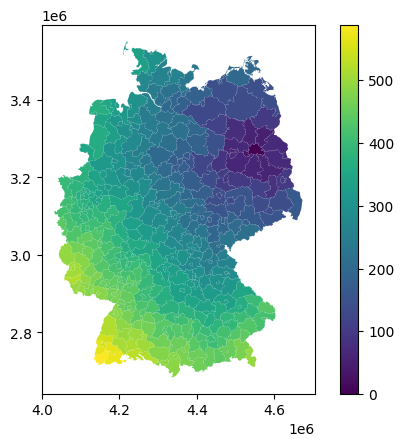

In [14]:
#Map the travel time from HUB to all other zones:
times = G.distances(source=[oID], target=list(range(len(gdfZones))), weights='travel_time', mode='out')
gdfZones['travel_time'] = times[0]
gdfZones['travel_time'] = gdfZones['travel_time']
print("Travel times from Berlin (in minutes).")
gdfZones.plot('travel_time', legend=True); # scheme='quantiles'

### 5. Adjusting and exporting the OD Matrix

In [15]:
# Extract unique block values 
plzs = gdfZones['kreis_id'].unique()

results = {}  # Dictionary to store OD results keyed by block

for plz in plzs:
    # Retrieve oIDs
    oID = mappingPlzToID.get(plz)  # Using .get() to avoid KeyError if block is not found
    
    if oID is not None:  # Proceed only if the block was found in the mapping
        # Calculate distances
        OD = G.distances(source=[oID], target=list(range(len(gdfZones))), weights='travel_time', mode='out')
        
        # Store or process the OD result
        # Here, we're just storing it in a dictionary for simplicity
        results[plz] = OD
    else:
        # Handle cases where the block is not found in the mapping
        print(f"Block {plz} not found in mapping.")

# At this point, `results` will contain all the OD results keyed by PLZ


In [16]:
# Convert the OD results dictionary into a DataFrame
# This assumes each entry in 'results' is a list or array of distances
df_OD = pd.DataFrame.from_dict(results, orient='index')

# Optionally, give names to columns for clarity
df_OD.columns = [f"Dest_{i}" for i in range(len(df_OD.columns))]

# Show the DataFrame
print(df_OD)

                                                    Dest_0
1001.0   [0.0, 63.959844553231065, 127.9629423154075, 6...
1002.0   [63.95984455323107, 0.0, 73.58254113691322, 28...
1003.0   [127.96294231540745, 73.58254113691324, 0.0, 6...
1004.0   [69.44602402112737, 28.57819620917733, 63.1719...
1051.0   [87.57282681987476, 73.12199590408359, 120.704...
...                                                    ...
16073.0  [451.1381963390742, 410.2703685271244, 390.346...
16074.0  [410.3938829914923, 369.5260551795425, 343.113...
16075.0  [436.3043343547436, 395.4365065427938, 369.024...
16076.0  [430.1548457695627, 389.2870179576129, 362.874...
16077.0  [423.7652710535105, 382.89744324156067, 356.48...

[401 rows x 1 columns]


In [17]:
# Assuming `df` is your current DataFrame
# Extract the lists from the DataFrame's column
lists = df_OD['Dest_0'].tolist()

# Create a new DataFrame from the lists
new_df = pd.DataFrame(lists)

# If you want to preserve the original row labels (index) from df to new_df:
new_df.index = df_OD.index
new_df.columns = new_df.index

In [18]:
display(pd.DataFrame(new_df))

,1001.0,1002.0,1003.0,1004.0,1051.0,1053.0,1054.0,1055.0,1056.0,1057.0,...,16068.0,16069.0,16070.0,16071.0,16072.0,16073.0,16074.0,16075.0,16076.0,16077.0
1001.0,0.000000,63.959845,127.962942,69.446024,87.572827,144.683795,42.563091,123.903818,104.904421,88.292782,...,379.089936,445.173914,411.116433,413.341459,465.395027,451.138196,410.393883,436.304334,430.154846,423.765271
1002.0,63.959845,0.000000,73.582541,28.578196,73.121996,90.303394,86.409527,64.204067,64.036594,28.593030,...,338.222108,404.306087,370.248605,372.473632,424.527199,410.270369,369.526055,395.436507,389.287018,382.897443
1003.0,127.962942,73.582541,0.000000,63.171957,120.704634,42.405370,150.412625,40.187827,77.246579,68.236041,...,318.298375,384.382353,350.324872,352.549898,404.603466,390.346635,343.113796,369.024248,362.874759,356.485184
1004.0,69.446024,28.578196,63.171957,0.000000,65.368296,79.892810,91.895706,78.112260,45.327920,49.051936,...,319.513435,385.597413,351.539931,353.764958,405.818525,391.561695,350.817381,376.727833,370.578344,364.188769
1051.0,87.572827,73.121996,120.704634,65.368296,0.000000,114.774703,68.048010,133.065970,56.583137,97.454934,...,344.686926,410.770904,376.713422,378.938449,430.992016,416.735186,375.990872,401.901324,395.751835,389.362260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16073.0,451.138196,410.270369,390.346635,391.561695,416.735186,373.445750,471.743311,412.081825,362.306176,427.360365,...,84.357163,73.654374,48.538228,66.027958,43.884326,0.000000,70.160385,57.517789,81.894697,106.952851
16074.0,410.393883,369.526055,343.113796,350.817381,375.990872,311.914695,430.998997,371.311080,321.561863,386.616052,...,57.968925,102.341936,57.307901,31.202287,100.723971,70.160385,0.000000,43.336361,37.186872,49.011458
16075.0,436.304334,395.436507,369.024248,376.727833,401.901324,337.825146,456.909449,397.221531,347.472314,412.526503,...,92.750336,114.269644,82.599397,65.983698,81.892574,57.517789,43.336361,0.000000,45.264859,70.323012
16076.0,430.154846,389.287018,362.874759,370.578344,395.751835,331.675658,450.759960,391.072042,341.322826,406.377015,...,86.600847,130.973858,85.939823,59.834209,110.851162,81.894697,37.186872,45.264859,0.000000,47.660159


#### Exporting Matrix to Stata

In [19]:
# Export the DataFrame to a Stata .dta file
# new_df.to_stata('C:/Users/andre/Dropbox/_HUB_HerreraA/Course/Repository/Workspaces_by_Topic/Topic_09/od_matrix.dta');

#### Exporting Matrix to Matlab

In [42]:
from scipy.io import savemat

# Convert the DataFrame to a NumPy array
data_array = new_df.to_numpy()

# Optional: Add East West Border
# condition_east_germany = gdfZones['AGS'].str.startswith('11') | gdfZones['AGS'].str.startswith('12') | gdfZones['AGS'].str.startswith('13') | gdfZones['AGS'].str.startswith('14') | gdfZones['AGS'].str.startswith('15') | gdfZones['AGS'].str.startswith('16')
# mask_east_germany = np.tile(condition_east_germany[:, None], (1, 401)).astype(int) + np.tile(condition_east_germany[:, None].T, (401, 1)).astype(int) == 1
# data_array = data_array[mask_east_germany] * 1000

# Create a dictionary to store your data; keys are variable names used in MATLAB
mat_data = {'data_matrix': data_array}

# Define your file path and name
file_path = f'{ROOT_FOLDER}/notebooks/tutorial_11/od_matrix.mat'
# file_path = f'{ROOT_FOLDER}/notebooks/tutorial_11/od_matrix_border.mat'
# file_path = f'{ROOT_FOLDER}/notebooks/tutorial_11/od_matrix_autobahn.mat'

# Use savemat to save the dictionary to a .mat file
savemat(file_path, mat_data)

In [21]:
#!pip install dill
#import dill
# dill.dump_session('C:/Users/andre/Dropbox/_HUB_HerreraA/Course/Repository/Workspaces_by_Topic/Topic_09/travel_time_session.db')

---